In [1]:
import sympy as sp
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact

from commpy.utilities import upsample

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pulseShape, lowPassFIR, pnorm, sincInterp
from optic.metrics import signal_power
from optic.plot import eyediagram, pconst

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:,d}'.format

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
figsize(6, 3)

# Transmissão Digital da Informação

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Canais-limitados-em-banda" data-toc-modified-id="Canais-limitados-em-banda-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Canais limitados em banda</a></span></li><li><span><a href="#Sinalização-para-canais-limitados-em-banda" data-toc-modified-id="Sinalização-para-canais-limitados-em-banda-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sinalização para canais limitados em banda</a></span><ul class="toc-item"><li><span><a href="#Interferência-intersimbólica-(ISI)" data-toc-modified-id="Interferência-intersimbólica-(ISI)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Interferência intersimbólica (ISI)</a></span></li><li><span><a href="#Critério-de-Nyquist-para-ausência-de-interferência-intersimbólica" data-toc-modified-id="Critério-de-Nyquist-para-ausência-de-interferência-intersimbólica-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Critério de Nyquist para ausência de interferência intersimbólica</a></span></li><li><span><a href="#Família-de-pulsos-cosseno-levantado-(raised-cosine)" data-toc-modified-id="Família-de-pulsos-cosseno-levantado-(raised-cosine)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Família de pulsos cosseno levantado (<em>raised cosine</em>)</a></span></li><li><span><a href="#Transmissão-de-sinais-com-resposta-parcial" data-toc-modified-id="Transmissão-de-sinais-com-resposta-parcial-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Transmissão de sinais com <em>resposta parcial</em></a></span></li></ul></li><li><span><a href="#Referências" data-toc-modified-id="Referências-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

# Receptores ótimos para canais AWGN

<img src="./figuras/Fig1.png" width="900">
 <center>Fig.1: Diagrama de blocos de um sistema de transmissão digital genérico.</center>

##  Canais limitados em banda

Na maioria das situações práticas, a transmissão digital deve ser estabelecida por meio de um canal cuja banda de frequências disponível para comunicação é limitada. Desse modo, existirão restrições sobre o conteúdo de frequências que os sinais transmitidos e recebidos poderão conter. 

Na análise que segue, considere que o canal de comunicações pode ser modelado como um sistema linear com uma resposta ao impulso $h(t)$ e resposta em frequência $H(f)$ limitada a uma banda de $B$ Hz, de modo que 

$$
\begin{equation}
H(f) = \begin{cases}|H(f)|e^{\theta(f)}, & |f|<B \\ 0, & \text { caso contrário.}\end{cases}
\end{equation}
$$

e $H(f) = \int_{-\infty}^{\infty}h(t)e^{-2\pi f t} dt$, $|H(f)|$ é a resposta de amplitude e $\theta(f)$ a resposta de fase do canal. A partir da resposta de fase podemos definir o *atraso de grupo* como 

$$
\begin{equation}
\tau(f)=-\frac{1}{2 \pi} \frac{d \theta(f)}{d f}.
\end{equation}
$$

O atraso de grupo corresponde ao intervalo de tempo com que cada componente de frequência do sinal transmitido atravessa o canal linear. Um canal linear não causará distorção nos sinais por ele transmitidos se, por todo o espectro do sinal transmitido, $|H(f)|$ for constante e $\theta(f)$ for uma função linear de $f$, ou seja, se o atraso de grupo for constante.

## Sinalização para canais limitados em banda

Assuma que em cada intervalo de sinalização $T_s$, o transmissor envia um sinal $s_m(t)$ dentre os $M$ possíveis do esquema de modulação utilizado, i.e. $\left\lbrace s_m(t), m = 1,2,\dots, M\right\rbrace$. Considere que no intervalo de $0\leq t \leq T_s$ o transmissor enviou a sinal $s_m(t)$. Após a filtragem do canal os sinais transmitidos são afetados apenas por AWGN, como ilustrado na Fig. 2. 

<img src="./figuras/Fig12.png" width="600">

<center>Fig.2: Esquemático de um sistema de transmissão digital via canal linear e AWGN.</center>

Desse modo, o sinal $r(t)$ que chega a entrada do receptor pode ser representado por


$$
\begin{align}
r(t) & =\left[\sum_{k=-\infty}^{\infty} s_k p\left(t-k T_s\right)\right] \ast h(t) + n(t)\nonumber \\
& =\sum_{k=-\infty}^{\infty} s_k p(t)\ast \delta\left(t-k T_s\right) \ast h(t) + n(t)\nonumber \\
& =\sum_{k=-\infty}^{\infty} s_k p(t)\ast h(t)\ast\delta\left(t-k T_s\right)  + n(t)\nonumber \\
& =\sum_{k=-\infty}^{\infty} s_k g(t)\ast\delta\left(t-k T_s\right)  + n(t)\nonumber \\
& =\sum_{k=-\infty}^{\infty} s_k g\left(t-k T_s\right)  + n(t) \label{ch_model_1}\\
\end{align}
$$

em que $g(t)$ é o pulso resultante da convolução de $p(t)$ com a resposta ao impulso do canal $h(t)$.

### Interferência intersimbólica (ISI)

Assuma que no receptor o sinal $r(t)$ é filtrado e amostrado nos instantes $t=qT_s + \tau_{0}, q=0, 1, \ldots$. Seja a saída do filtro do receptor dada por

$$
\begin{equation}
y(t)=\sum_{k=-\infty}^{\infty} s_k x(t-kT_s) + u(t)
\end{equation}
$$

temos

$$
\begin{equation}
y\left(q T_s+\tau_0\right) \equiv y_q=\sum_{k=-\infty}^{\infty} s_k x\left(qT_s- kT_s+\tau_0\right) + u\left(qT_s+\tau_0\right)
\end{equation}
$$

em que $\tau_{0}$ é o atraso de propagação do sinal pelo canal. Considerando apenas a representação discreta do sinal, temos 

$$
\begin{align}
y_q&=\sum_{k=-\infty}^{\infty} s_k x_{q-k}+u_q, \quad q=0,1, \ldots.\nonumber\\
&= x_0\left(s_q+\frac{1}{x_0} \sum_{\substack{k=-\infty \\ k \neq q}}^{\infty} s_k x_{q-k}\right)+u_q, \quad q=0,1, \ldots
\end{align}
$$

em que $x_0$ é um fator de escala arbitrário que pode ser considerado igual à unidade por conveniência, de modo que

$$
\begin{equation}\label{ISI_eq1}
y_q=s_q + \sum_{\substack{k=-\infty \\ k \neq q}}^{\infty} s_k x_{q-k} + u_q, \quad q=0,1, \ldots
\end{equation}
$$

Em ($\ref{ISI_eq1}$), temos que $s_q$ é o símbolo transmitido no intervalo de sinalização $q$. Já o termo $\sum_{\substack{k=-\infty \\ k \neq q}}^{\infty} s_k x_{q-k}$ representa a interferência causada em $s_q$ pelos demais símbolos transmitidos, denominada **interferência intersimbólica** (*intersymbol interference* - ISI). Por fim, $u_q$ é uma variável aleatória representado o ruído AWGN no instante de sinalização $q$.


C:\Users\edson\anaconda3\lib\site-packages\numpy\ma\core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


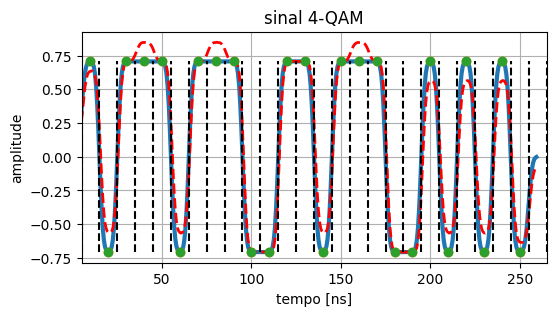

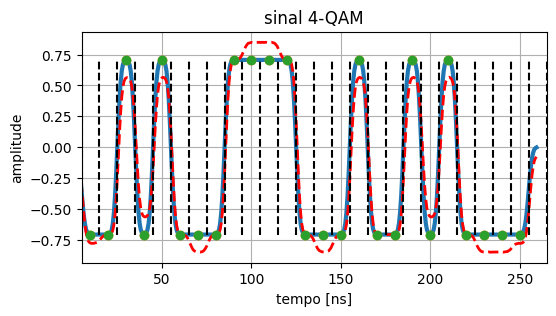

In [6]:
M = 4
constType = 'qam'

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# gera sequência pseudo-aleatória de bits
bitsTx = np.random.randint(2, size = int(25*np.log2(M)))

# gera sequência de símbolos modulados
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization
symbTx = np.insert(symbTx,0, 0)

# resposta do canal linear
h_ch = np.array([0, 0.1, 1, 0.1])

# upsampling
symbolsUp = upsample(symbTx, SpS)
h_ch_Up = upsample(h_ch, SpS)
h_ch_Up = h_ch_Up.real

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

t = np.arange(sigTx.size)*Ta/1e-9

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(symbTx, SpS)
symbolsUp[symbolsUp==0+1j*0] = np.nan + 1j*np.nan

if constType == 'pam':
    plt.figure(2)
    plt.plot(t, sigTx,'-',linewidth=2)
    plt.plot(t, symbolsUp.real,'ko')
    plt.xlabel('tempo [ns]')
    plt.ylabel('amplitude')
    plt.title('sinal '+str(M)+'-PAM')
    plt.grid()
else:
    plt.figure(2)
    plt.plot(t, sigTx.real,'-',linewidth=3, label = '$Re\{s_n\}$')
    plt.plot(t, symbolsUp.real,'o')
    plt.xlabel('tempo [ns]')
    plt.ylabel('amplitude')
    plt.title('sinal '+str(M)+'-QAM')
    plt.grid()
    
    plt.figure(3)
    plt.plot(t, sigTx.imag,'-',linewidth=3, label = '$Im\{s_n\}$')
    plt.plot(t, symbolsUp.imag,'o')
    plt.xlabel('tempo [ns]')
    plt.ylabel('amplitude')
    plt.title('sinal '+str(M)+'-QAM')
    plt.grid()

# canal linear
sigRx = firFilter(h_ch_Up, sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 1e-6  # variância
μ   = 0      # média

σ      = np.sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)
ruidoC  = (normal(μ, σ, Namostras) + 1j*normal(μ, σ, Namostras))/np.sqrt(2)

t = np.arange(sigTx.size)*Ta/1e-9
if constType == 'pam':
    plt.figure(2)
    plt.plot(t, (sigRx + ruido).real,'r--',alpha=1, linewidth=2)
    t = (0.5*Ts + np.arange(0, symbTx.size+1)*Ts)/1e-9
    plt.vlines(t, min(symbTx), max(symbTx), linestyles='dashed', color = 'k');
    plt.xlim(min(t), max(t));
else:
    plt.figure(2)
    plt.plot(t, (sigRx + ruidoC).real,'r--',alpha=1, linewidth=2)
    plt.plot(t, symbolsUp.real,'o')
    plt.figure(3)
    plt.plot(t, (sigRx + ruidoC).imag,'r--',alpha=1, linewidth=2)
    plt.plot(t, symbolsUp.imag,'o')
    t = (0.5*Ts + np.arange(0, symbTx.size+1)*Ts)/1e-9
    plt.figure(2)
    plt.vlines(t, min(symbTx), max(symbTx), linestyles='dashed', color = 'k');
    plt.xlim(min(t), max(t));
    plt.figure(3)
    plt.vlines(t, min(symbTx), max(symbTx), linestyles='dashed', color = 'k');
    plt.xlim(min(t), max(t));

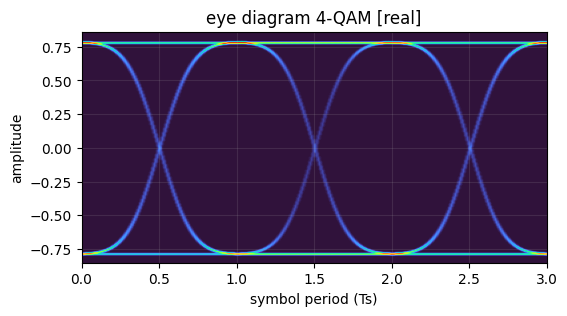

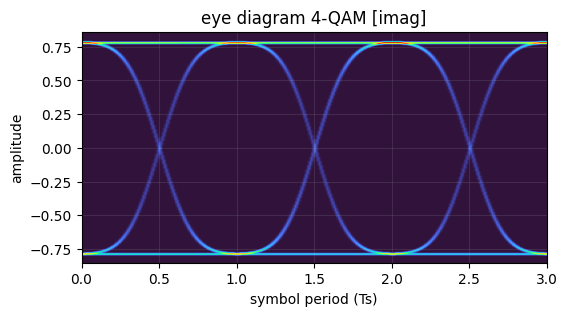

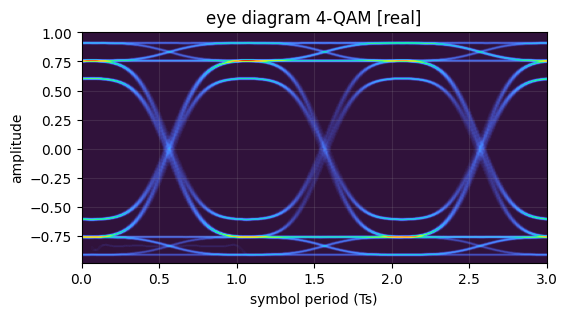

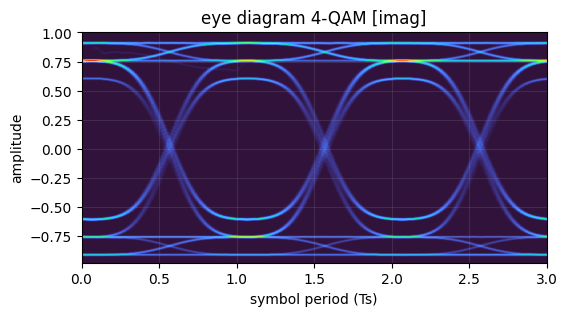

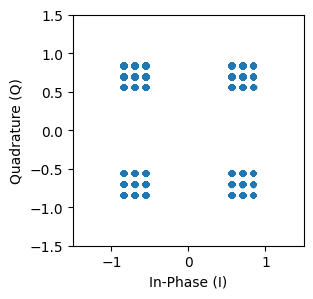

In [7]:
# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(250000*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

# resposta do canal linear
h_ch = np.array([0, 0.1, 1, 0.1])

# upsampling
symbolsUp = upsample(symbTx, SpS)
h_ch_Up = upsample(h_ch, SpS)
h_ch_Up = h_ch_Up

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# canal linear
sigRx = firFilter(h_ch_Up, sigTx)
sigRx = pnorm(sigRx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 1e-7 # variância
μ   = 0         # média

σ      = np.sqrt(σ2*SpS)
ruido  = normal(μ, σ, Namostras)
ruidoC  = (normal(μ, σ, Namostras) + 1j*normal(μ, σ, Namostras))/np.sqrt(2)

# diagrama de olho
Nsamples = sigTx.size
if constType == 'pam':
    eyediagram(sigTx.real, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
    eyediagram((sigRx + ruido).real, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
else:
    eyediagram(sigTx, Nsamples, SpS, plotlabel= str(M)+'-QAM', ptype='fancy')
    eyediagram(sigRx + ruidoC, Nsamples, SpS, plotlabel= str(M)+'-QAM', ptype='fancy')
    
pconst(pnorm((sigRx + ruidoC)[10*SpS:-10*SpS:SpS]), pType='fast', R=1.5);

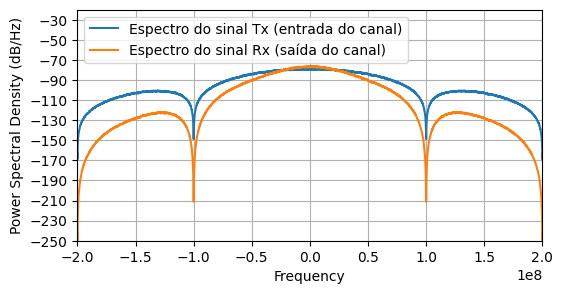

In [8]:
# plot PSD
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-250,-20);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Tx (entrada do canal)')
plt.psd(pnorm(firFilter(pulse, sigRx)),Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do canal)')
plt.legend(loc='upper left');

### Critério de Nyquist para ausência de interferência intersimbólica

Considere que a resposta em frequência $H(f)$ é ideal e limitada em banda, de maneira que

$$
\begin{equation}
|H(f)| = \begin{cases}1, & |f|<B \\ 0, & \text { caso contrário.}\end{cases}.
\end{equation}
$$

Logo, assumindo que o receptor aplica um filtro casado ao pulso $p(t)$ transmitido, temos que $X(f) = |P(f)|^2$, em que

$$
\begin{equation}
x(t) = \int_{-B}^{B}X(f)e^{2\pi f t} df.
\end{equation}
$$

Desejamos encontrar as condições que $p(t)$ deve atender e, por consequência, $x(t)$, para que a interferência intersimbólica seja nula. Sabemos que

$$
\begin{equation}\label{ISI_eq2}
y_q=s_q + \sum_{\substack{k=-\infty \\ k \neq q}}^{\infty} s_k x_{q-k} + u_q, \quad q=0,1, \ldots,
\end{equation}
$$

o que implica que a condição para ausência de ISI é dada por

$$
\begin{equation}\label{isi_x}
x(t=q T_s) \equiv x_q= \begin{cases}1, & q=0 \\ 0, & q \neq 0\end{cases}
\end{equation}
$$

Esta condição é conhecida como critério de Nyquist para ausência de interferência intersimbólica.

**Teorema (Critério de Nyquist)**: uma condição necessária e suficiente para a ausência de interferência intersimbólica, ou seja, para $x(t)$ satisfazer ($\ref{isi_x}$) é que sua transformada de Fourier $X(f)$ satisfaça

$$
\sum_{m=-\infty}^{\infty} X(f+m R_s)=T_s.
$$


Prova:

$$
\begin{equation}
x(t)=\int_{-\infty}^{\infty} X(f) e^{j 2 \pi f t} d f
\end{equation}
$$

Considerando que as amostras são tomadas ao final de cada intervalo de sinalização $t=kT_s$, temos que
$$
\begin{equation}
x(kT_s)=\int_{-\infty}^{\infty} X(f) e^{j 2 \pi f k T_s} d f.
\end{equation}
$$

A taxa de sinalização, ou taxa de símbolos, $R_s$ é dada por $R_s = 1/T_s$, de modo que

$$
\begin{align}
x(kT_s) & =\sum_{m=-\infty}^{\infty} \int_{(2 m-1) R_s/2}^{(2 m+1) R_s/2} X(f) e^{j 2 \pi f kT_s} d f\nonumber \\
& =\sum_{m=-\infty}^{\infty} \int_{-R_s/2}^{R_s/2} X(f+ m R_s) e^{j 2 \pi f kT_s} d f \nonumber\\
& =\int_{-R_s/2}^{R_s/2}\left[\sum_{m=-\infty}^{\infty} X(f+m R_s)\right] e^{j 2 \pi f kT_s} d f \nonumber\\
& =\int_{-R_s/2}^{R_s/2} B(f) e^{j 2 \pi f kT_s} d f\label{nyq_1}
\end{align}
$$

Em que a função $B(f)$ é dada por
$$
\begin{equation}
B(f)=\sum_{m=-\infty}^{\infty} X(f+mR_s).
\end{equation}
$$

Como $B(f)$ é periódica em $f$ com período $R_s$, esta admite representação em termos de uma série de Fourier

$$
\begin{align}
B(f)&=\sum_{k=-\infty}^{\infty} b_k e^{j 2 \pi k f T_s} \nonumber \\
b_k&=\frac{1}{R_s} \int_{-R_s / 2}^{R_s/ 2} B(f) e^{-\frac{j2 \pi k f}{R_s}} d f = T_s \int_{-R_s / 2}^{R_s/ 2} B(f) e^{-j2 \pi k f T_s} d f \label{nyq_2}
\end{align}
$$

Logo, comparando ($\ref{nyq_1}$) e ($\ref{nyq_2}$), temos que

$$
\begin{equation}
b_k=T_s x(-k T_s).
\end{equation}
$$

Desse modo, na ausência de ISI, os coeficientes $b_k$ devem ser dados por
$$
\begin{equation}\label{fourier_coeffs}
b_k=\begin{cases}T_s, & k=0 \\ 0, & k \neq 0\end{cases}.
\end{equation}
$$

o que implica em

$$
\begin{align}
B(f)&=T_s\\
\sum_{m=-\infty}^{\infty} X(f+m R_s)&=T_s.
\end{align}
$$

Supondo que o canal tem banda $B$, teremos então três casos 

1. Se $R_s > 2B$, as cópias de $X(f)$ espaçadas de $R_s$ no domínio da frequência não se sobrepõem, de modo que não há nenhuma escolha possível de $x(t)$ que permita que $\sum_{m=-\infty}^{\infty} X(f+m R_s)$ seja uma função constante. Como consequência, não existe nenhuma função $x(t)$ que permita a transmissão livre de ISI.

2. Se $R_s = 2B$, o somatório $\sum_{m=-\infty}^{\infty} X(f+m R_s)$ será uma constante apenas se $X(f)$ for uma função porta
$$
\begin{equation}
X(f)= \begin{cases}T_s & |f|<B \\ 0, & \text { c.c. }\end{cases}
\end{equation}
$$

ou seja, se $x(t)$ for uma função sinc

$$
\begin{equation}
x(t)=\operatorname{sinc}\left(\frac{t}{T_s}\right).
\end{equation}
$$

3. Se $R_s < 2B$, os temos do somatório $\sum_{m=-\infty}^{\infty} X(f+m R_s)$ se sobrepõem, de modo que existirão diversas escolhas de $x(t)$ que o mesmo seja constante.


### Família de pulsos cosseno levantado (*raised cosine*)

Um conjunto de pulsos que atendem ao critério de Nyquist de ISI nula correponde à família de pulsos cosseno levantado, que pode ser definida no domínio da frequência como
$$
\begin{equation}
X_{r c}(f)= \begin{cases}T_s, & 0 \leq|f| \leq(1-\alpha) / 2 T_s \\ \frac{T_s}{2}\left[1+\cos \frac{\pi T_s}{\alpha}\left(|f|-\frac{1-\alpha}{2 T_s}\right)\right], & \frac{1-\alpha}{2 T_s} \leq|f| \leq \frac{1+\alpha}{2 T_s} \\ 0, & |f|>\frac{1+\alpha}{2 T_s}\end{cases}
\end{equation}
$$
e no domínio do tempo como
$$
\begin{align}
x(t) & =\frac{\operatorname{sen} (\pi t / T_s)}{\pi t / T_s} \frac{\cos (\pi \alpha t / T_s)}{1-4 \alpha^2 t^2 / T_s^2}\nonumber \\
& =\operatorname{sinc}(t / T_s)\frac{\cos (\pi \alpha t / T_s)}{1-4 \alpha^2 t^2 / T_s^2},
\end{align}
$$

em que $0<\alpha<1$ é denominado de parâmetro de *rolloff* ou *excesso de banda*.

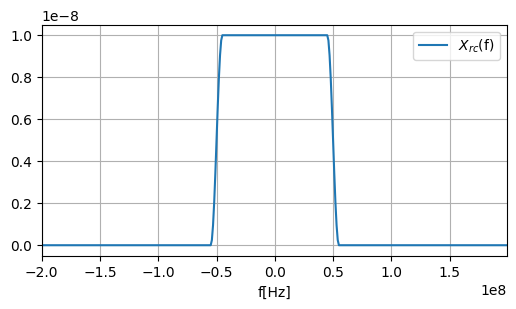

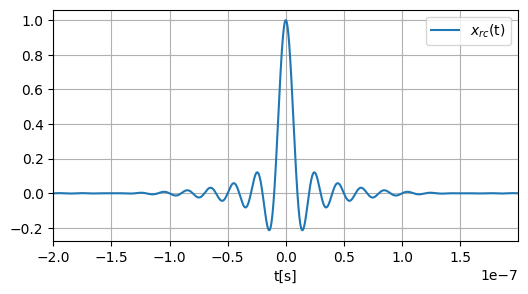

In [14]:
Rs = 100e6
Ts = 1/Rs
α = 0.1
π = sp.pi

f, t = sp.symbols('f, t', real=True)

X = sp.Piecewise((0, ( f  <= -(1 + α)/(2*Ts) ) ), 
                  ((Ts/2)*(1 + sp.cos(π*Ts/α*(sp.Abs(f)-(1-α)/(2*Ts)))), ( f  > -(1 + α)/(2*Ts) )&( f <= -(1-α)/(2*Ts)  ) ) , 
                  (Ts, ( f  > -(1-α)/(2*Ts) )&( f <= (1-α)/(2*Ts))  ) ,
                  ((Ts/2)*(1 + sp.cos(π*Ts/α*(sp.Abs(f)-(1-α)/(2*Ts)))), ( f  > (1-α)/(2*Ts) )&( f <= (1+α)/(2*Ts))  ),
                  (0, ( f  > (1+α)/(2*Ts) ) ) ) 

x = sp.sinc(π*t/Ts)*sp.cos(π*α*t/Ts)/(1-4*α**2*t**2/Ts**2)

finterval = np.arange(-2, 2, 0.01)*(1/Ts)
symplot(f, X, finterval, '$X_{rc}$(f)', xlabel = 'f[Hz]');

tinterval = np.arange(-20, 20, 0.01)*Ts
symplot(t, x, tinterval, '$x_{rc}$(t)', xlabel = 't[s]');

Duas vantagens importantes:

1. Devido às características suaves de transição de $x_{rc}(t)$ estes pulsos podem ser implementados na prática por filtros lineares formatadores de pulso.

2. As bordas laterais dos pulsos $x_{rc}(t)$ convergem para 0 a uma taxa proporcional a $1/t^3$, para $\alpha>0$, diferentemente da função $\operatorname{sinc}(t)$, que convege a $1/t$. Essa proprieadade permite que pequenos desvios do instante de amostragem ótimo façam com que a ISI convirja para um valor finito no caso do pulso $x_{rc}(t)$, enquanto a mesma diverge no caso de pulsos $\operatorname{sinc}(t)$. Assim, pulsos $x_{rc}(t)$ são em geral mais robustos à erros de sincronização do que pulsos $\operatorname{sinc}(t)$.

3. A complexidade do processamento requerido para a implementação de $x_{rc}(t)$ pode ser dividida entre transmissor e receptor. Considerando a situação ideal em que $$
\begin{equation}\nonumber
H(f) = \begin{cases}1, & |f|<B \\ 0, & \text { caso contrário.}\end{cases}
\end{equation}
$$Sejam $P_T(f)$ e $P_R(f) = P_T^*(f)$ os filtro formatador de pulso do transmissor e o filtro casado correspondente no receptor, respectivamente, temos que$$
\begin{align}
P_T(f)H(f)P_R(f) &= X_{rc}(f)\nonumber\\
P_T(f)P_R(f) &= X_{rc}(f)\nonumber\\
|P_T(f)|^2 &= X_{rc}(f)\nonumber\\
\end{align}
$$
ou seja, $X_{rc}(f)$ pode ser alcançada fazendo-se $P_T(f) = P_R^*(f) = \sqrt{X_{rc}(f)} = P_{rrc}(f)$. O pulso cujo espectro é dado por $P_{rrc}(f) = \sqrt{X_{rc}(f)}$ é conhecido como raiz do cosseno levantado (*root raised cosine* - RRC) e é definido no domínio do tempo por

$$
p_{rrc}(t)= \begin{cases}\frac{1}{T_s}\left(1+\alpha\left(\frac{4}{\pi}-1\right)\right), & t=0 \\ \frac{\alpha}{T_s \sqrt{2}}\left[\left(1+\frac{2}{\pi}\right) \sin \left(\frac{\pi}{4 \alpha}\right)+\left(1-\frac{2}{\pi}\right) \cos \left(\frac{\pi}{4 \alpha}\right)\right], & t= \pm \frac{T_s}{4 \alpha} \\ \frac{1}{T_s} \frac{\sin \left[\pi \frac{t}{T_s}(1-\alpha)\right]+4 \alpha \frac{t}{T_s} \cos \left[\pi \frac{t}{T_s}(1+\alpha)\right]}{\pi \frac{t}{T_s}\left[1-\left(4 \alpha \frac{t}{T_s}\right)^2\right]}, & \text { caso contrário.}\end{cases}
$$

### Transmissão de sinais com *resposta parcial*

Para efeitos práticos, o critério de Nyquist nos indica que é possível projetar formas de pulso para eliminar a presença de ISI no receptor, desde que a taxa de sinalização $R_s$ da transmissão em símbolos/segundo seja tal que $R_s < 2B$, em que $B$ é a banda do canal de comunicações em Hz.

Entretanto, transmitir a uma taxa de $R_s = 2B$ sem ter que recorrer à utilização de pulsos $\operatorname{sinc}(t)$ ainda será possível, desde que uma determinada quantidade controlada de ISI possa ser tolerada no receptor. Por exemplo, suponha que

$$
x(k T_s)= \begin{cases} 1, & k=0,1 \\ 0, & \text { caso contrário. }\end{cases}
$$

e então, os coeficientes em ($\ref{fourier_coeffs}$) serão dados por 

$$
b_k= \begin{cases}T_s & k=0,-1 \\ 0 & \text { caso contrário, }\end{cases}
$$

de maneira que $B(f)=T_s + T_s e^{j 2 \pi f T_s} = T_s\left(1 + e^{j 2 \pi f T_s}\right)$

Se $R_s > 2B$, o problema continua sem solução. Já no caso de $R_s=2B$, $B(f)$ pode ser alcançado se fizermos 

$$
\begin{align} 
X(f) & = \begin{cases}\frac{1}{2 B}\left(1+e^{-j \pi f / B}\right) & |f|<B \\ 0 & \text { caso contrário} \end{cases}\nonumber \\ 
& = \begin{cases}\frac{1}{B} e^{-j \pi f / 2 B} \cos\left( \frac{\pi f}{2 B}\right) & |f|<B \\ 0 & \text { caso contrário}\end{cases}. \nonumber\end{align}
$$

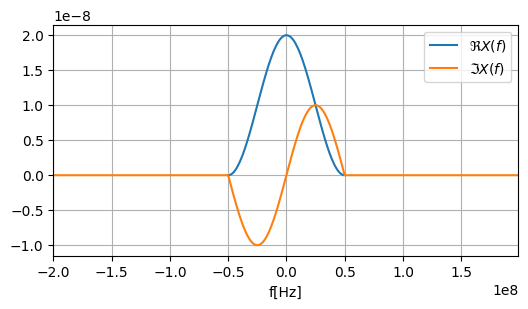

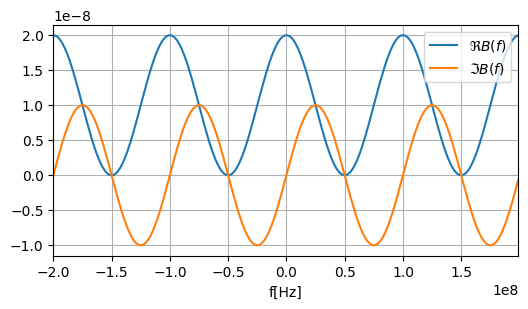

In [30]:
Rs = 100e6
Ts = 1/Rs
B = Rs/2

π = sp.pi

f, t = sp.symbols('f, t', real=True)

Bf = Ts + Ts*sp.exp(1j*2*π*f*Ts)

X = sp.Piecewise((1/(2*B)*(1 + sp.exp(1j*π*f/B)), (-B<= f)&(f<= B)), (0, ( f > B )& (f< -B) )) 

finterval = np.arange(-2, 2, 0.01)*2*B
symplot(f, [sp.re(X), sp.im(X)], finterval, ['$\Re{X(f)}$', '$\Im{X(f)}$'], xlabel = 'f[Hz]');
symplot(f, [sp.re(Bf), sp.im(Bf)], finterval, ['$\Re{B(f)}$','$\Im{B(f)}$'], xlabel = 'f[Hz]');

No domínio do tempo, o pulso associado a $X(f)$ é dado por

$$
x(t)=\operatorname{sinc}(2 \pi B t)+\operatorname{sinc}\left(2\pi B(t-T_s)\right)
$$

que é conhecido como *pulso duobinário*.


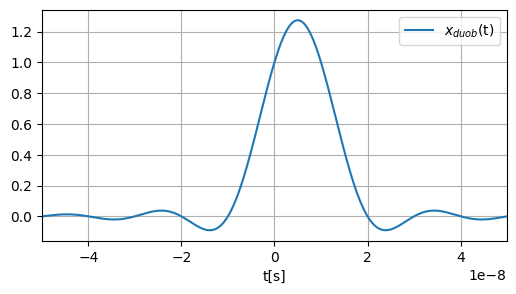

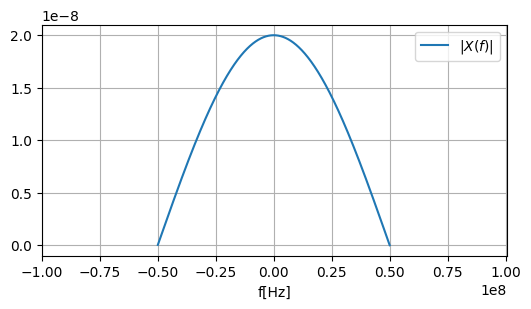

In [37]:
x = sp.sinc(2*B*π*t)+sp.sinc(2*B*π*(t-Ts))

tinterval = np.arange(-5, 5, 0.01)*Ts
symplot(t, x, tinterval, '$x_{duob}$(t)', xlabel = 't[s]');

finterval = np.arange(-2, 2.01, 0.001)*B
symplot(f, sp.Abs(X), finterval, '$|X(f)|$', xlabel = 'f[Hz]');

Outra possibilidade é fazer

$$
x(kT_s)= \begin{cases} 1, & k=-1 \\ -1, & k =1\\ 0, & \text { caso contrário. }\end{cases}
$$

que resultará no pulso

$$
x(t)=\operatorname{sinc}\left[2\pi B(t+T_s)\right]-\operatorname{sinc}\left[2\pi B(t-T_s)\right]
$$

cujo espectro é dado por

$$
X(f)= \begin{cases}\frac{1}{2 B}\left(e^{i \pi f / B}-e^{-j \pi f/ B}\right)=\frac{j}{B} \sin \left(\frac{\pi f}{B}\right) & |f|\leqslant B \\ 0 & |f| > B\end{cases}
$$

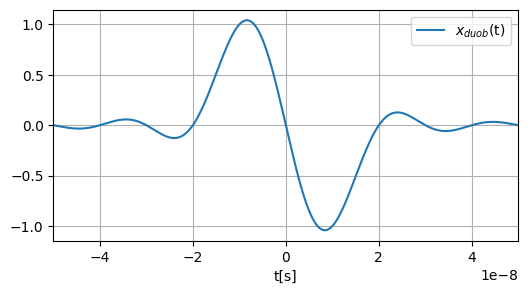

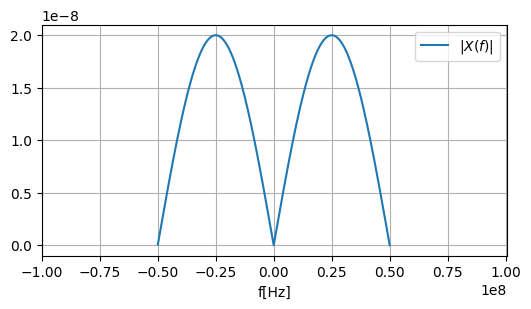

In [40]:
x = sp.sinc(2*B*π*(t+Ts))-sp.sinc(2*B*π*(t-Ts))

X = sp.Piecewise((1/(2*B)*(sp.exp(1j*π*f/B) - sp.exp(-1j*π*f/B)), (-B<= f)&(f<= B)), (0, ( f > B )& (f< -B) )) 

tinterval = np.arange(-5, 5, 0.0001)*Ts
symplot(t, x, tinterval, '$x_{duob}$(t)', xlabel = 't[s]');

finterval = np.arange(-2, 2.01, 0.001)*B
symplot(f, sp.Abs(X), finterval, '$|X(f)|$', xlabel = 'f[Hz]');

De maneira geral, os pulsos pertencentes ao conjunto de sinais limitados em banda dados por

$$
x(t)=\sum_{n=-\infty}^x x\left(\frac{n}{2 B}\right) \operatorname{sinc}\left[2 \pi B\left(t-\frac{n}{2 B}\right)\right]
$$

com espectro correspondente

$$
X(f)= \begin{cases}\frac{1}{2 B} \sum_{n=-\infty}^x x\left(\frac{n}{2 B}\right) e^{-j n \pi f / B} & |f| \leqslant B \\ 0 & |f| \leqslant B\end{cases}
$$

sâo denominados pulsos ou sinais de resposta parcial. A utilização de tais pulsos na transmissão significa a introdução controlada de ISI por meio da introdução de duas ou mais amostras não-nulas $x\left(\frac{n}{2 B}\right)$. Tais pulsos permitem a taxa de sinalização da transmissão seja igual a taxa de Nyquist, ou seja, $R_s = 2B$.

## Referências

[1] J. G. Proakis, M. Salehi, Communication Systems Engineering, 2nd Edition, Pearson, 2002.